# Tutorial 07: Diffusion models

**Topics of this tutorial**:
- Hands-on implementation of diffusion models
- Step by step example on *Flowers102* Dataset




# Diffusion models
<center>
<img src=https://github.com/CausalLearningAI/applied-dl-tutorials/blob/main/t07/imgs/example.png?raw=1>
</center>

Diffusion model is one of the **state-of-the-art generative models**. Diffusion models consists of two passses: the forward diffusion process and the reverse diffusion process. In the **forward diffusion process**, it gradually adds Gaussian noise to the original data  and then learning to remove the noise in the **reverse diffusion process**.




In [ ]:
#@title Imports
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
import math
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from torch.optim import Adam
import torch.nn.functional as F

# **Investigating the dataset**

As dataset we use the **Flowers102 Dataset**, consisting of 102 flower categories. The flowers chosen are flower that commonly occur in the United Kingdom. Each class consists of between 40 and 258 images.

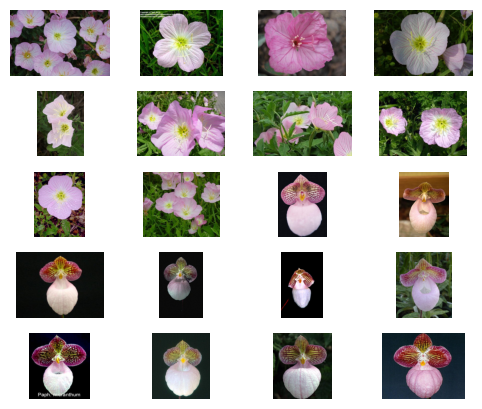

In [ ]:
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(5,5))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])
        plt.axis("off")
    plt.tight_layout()

data = torchvision.datasets.Flowers102(root=".", download=True)
show_images(data)

# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




**Forward diffusion**

We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

$$
q_t(x_t | x_{t-1}) = \mathcal{N}(x_t ~|~ \mu_t (x_{t-1}), \sigma^2_t I)
$$


**Linear scheduler as a common choice**

$$
\mu_t (x_{t-1}) = \sqrt{1 - \beta_t} \cdot x_{t-1} \qquad \sigma_t = \sqrt{\beta_t}
$$
So the forward sampling:
$$
x_t = \sqrt{1 - \beta_t} \cdot x_{t-1}  +  \sqrt{\beta_t} ϵ_t \qquad ϵ_t \sim \mathcal{N}(0, I)
$$

Let us define:
$$
\alpha_ t = 1 - \beta_t \qquad \bar \alpha_t = \prod_{s=1}^t \alpha_t
$$

Starting from $t=0$, we have:
$$
q(x_t | x_0) = \prod_{t=1}^T q_t(x_t | x_{t-1}) = \mathcal{N}(x_t ~|~ \sqrt{\bar \alpha_t} x_0, (1 - \bar \alpha_t) I)
$$


In [ ]:
#@title Some utility functions
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

#@title Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

There are many other types of schedulers: see https://huggingface.co/docs/diffusers/en/using-diffusers/schedulers

```
[diffusers.utils.dummy_torch_and_torchsde_objects.DPMSolverSDEScheduler,
 diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_ddim.DDIMScheduler,
 diffusers.schedulers.scheduling_ddpm.DDPMScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2DiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler]
```

### **An intuitive example with cosine scheduler**

<center>
<img src="https://i.imgur.com/JW9W0fA.gif" height="600">
</center>

In [ ]:
#@title Method: forward diffusion sample
def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

In [ ]:
#@title Data preprocessing
IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.Flowers102(root=".", download=True,
                                         transform=data_transform)

    test = torchvision.datasets.Flowers102(root=".", download=True,
                                         transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

<ipython-input-7-99063e96c68c>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


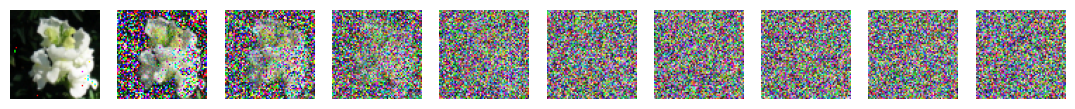

In [ ]:
#@title Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)
    plt.axis('off')

**Key Takeaways**:
- The **noise-levels/variances** can be pre-computed (chain of conditional distributions)
- There are different types of **variance schedules**
- We can sample each timestep image independently
- **No model** is needed in this forward step

## Step 2: The backward process




**Backward diffusion**

$$
p(x_{t-1} | x_t) = \mathcal{N}(x_{t-1} | \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t))
$$
where $\theta$ denotes the model weights.

$\Sigma_{\theta}(x_t, t)$ is usually diagonal, i.e. $\Sigma_{\theta}(x_t, t) = \sigma_{\theta}^2(t) I$. The author of the original paper of diffusion models decided to make $\sigma_{\theta}^2(t)$ time-dependent but not trainable. We follow this practice and use the pre-computed variance in the forward pass $\beta_t I$.

In the backward pass, the mean $\mu_{\theta}(x_t, t)$ is formulated as:
$$
\mu_{\theta}(x_t, t) = \dfrac{1}{\sqrt{\alpha_t}} \left(x_t - \dfrac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \epsilon_\theta(x_t, t)\right)
$$
where
$\epsilon_\theta(x_t, t)$ is our model output (predicted noise)

So, overall, the sampling process in backward pass follows the form:

$$
x_{t-1} = \dfrac{1}{\sqrt{\alpha_t}} \left(x_t - \dfrac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \epsilon_\theta(x_t, t)\right) + \sqrt{\beta_t} \epsilon
$$
Again, here $\epsilon \sim \mathcal{N}(0, I)$ is some standard noise.


Text(0, 0.5, 'Position')

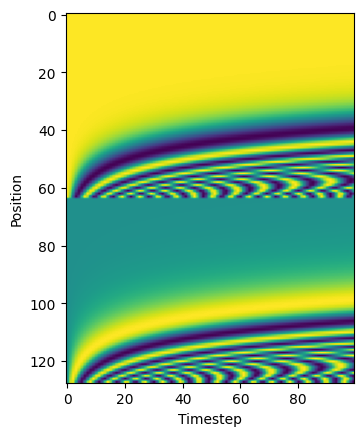

In [ ]:
#@title SubModule: Positional embedding
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

spe = SinusoidalPositionEmbeddings(128)
time = torch.arange(100).float()
result = spe(time)
plt.imshow(torch.rot90(result, 1, [0, 1]))
plt.xlabel("Timestep")
plt.ylabel("Position")

### U-net
U-net is was originally designed for semantic-segmentation in medical applications. The architecture consists of an encoder (for **downsampling**) and a decoder (for **upsampling**) with **skip connections**. As the following figure shows, it shapes like the letter U hence the name U-net (Figure credit: [U-net paper](https://arxiv.org/abs/1505.04597)).

Recently, it became favored in diffusion model pipelines primarily for its ability to efficiently manage and utilize information across different scales or resolutions of input data. At a high-level, UNet architecture is designed in a way that **captures both local and global information in an image**, making it particularly suitable for tasks that require understanding and manipulating images at different levels of detail—characteristics essential for the performance of diffusion models.

<center>
<img src="https://github.com/CausalLearningAI/applied-dl-tutorials/blob/main/t07/imgs/u-net.png?raw=1">
</center>


In [ ]:
#@title Model: U-net

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

**Key takeways**:
- We use a simple form of a **U-Net** for to predict the noise in the image
- The input is a noisy image, the **ouput the noise in the image**
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer **Sinusoidal Embedding**
- We output one single value (mean), because the variance is fixed

## Step 3: The loss



In [ ]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [ ]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

In [ ]:
from tqdm.notebook import tqdm

## Training

  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-11-a86ff88690cf>:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


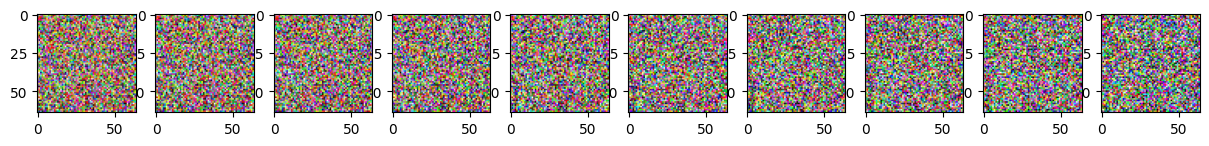

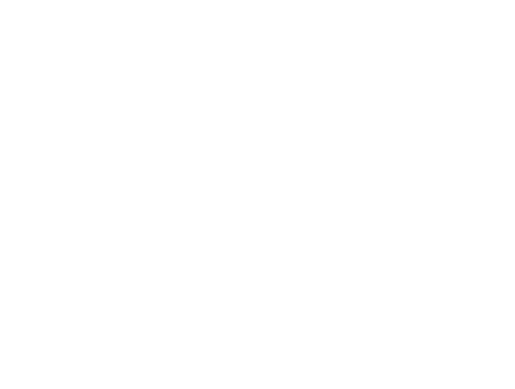

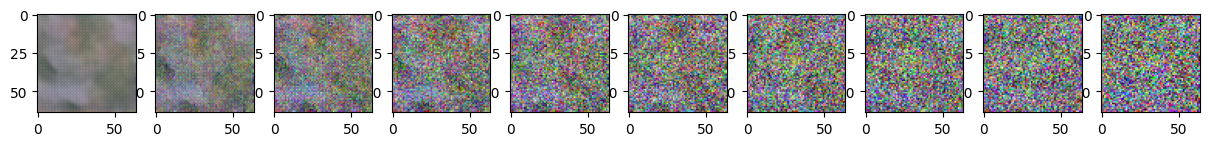

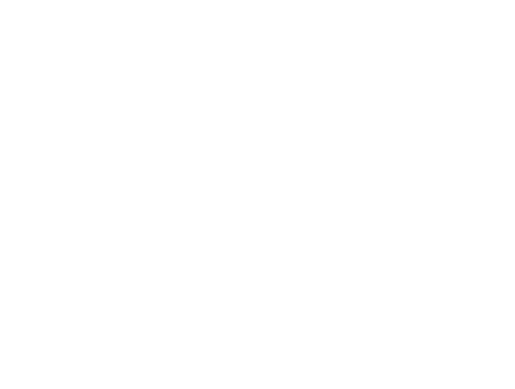

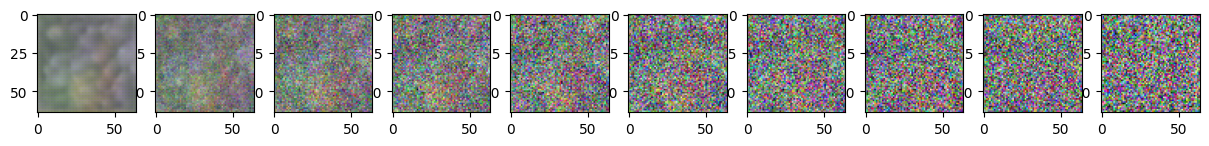

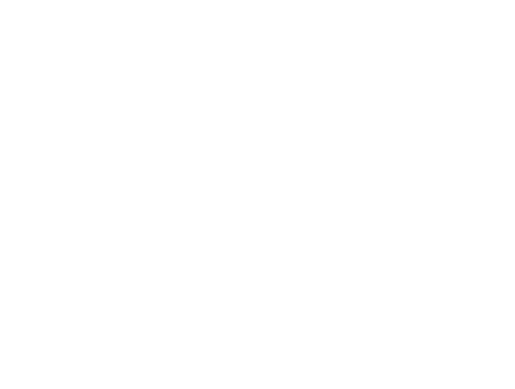

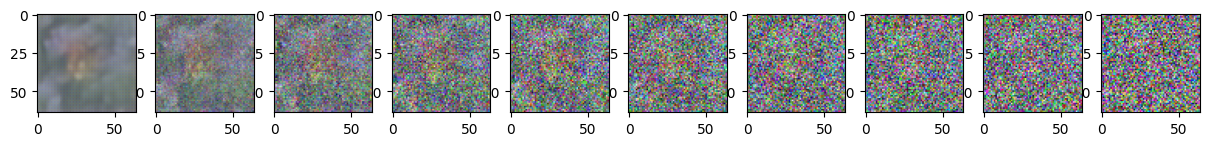

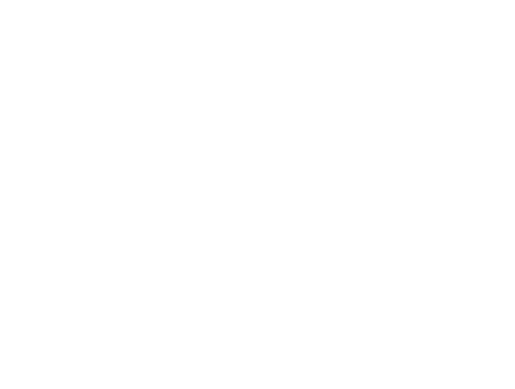

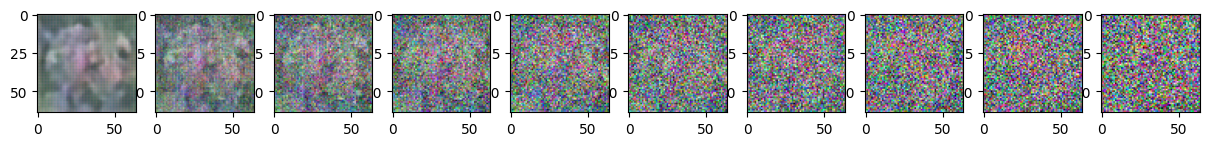

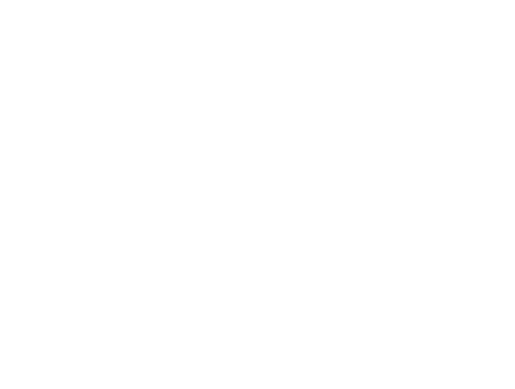

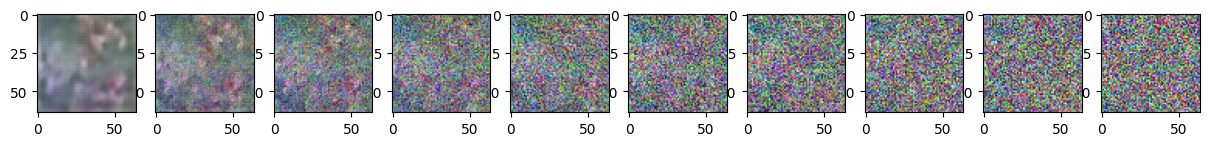

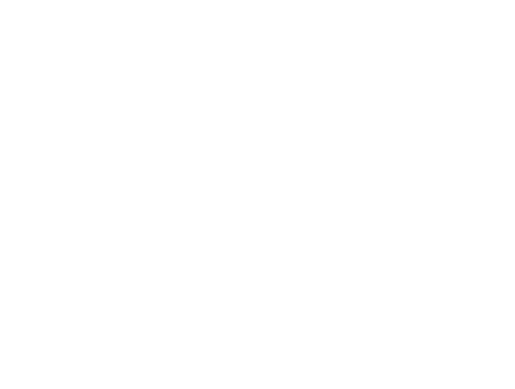

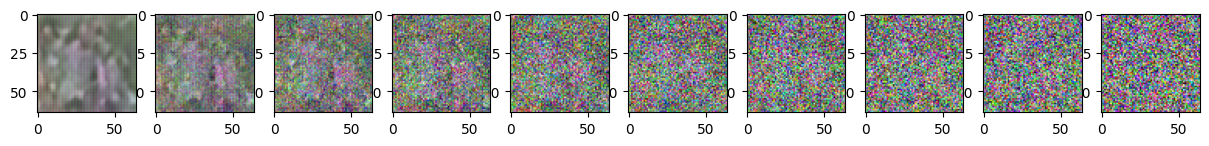

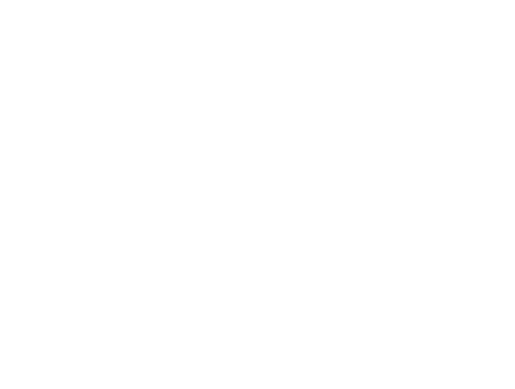

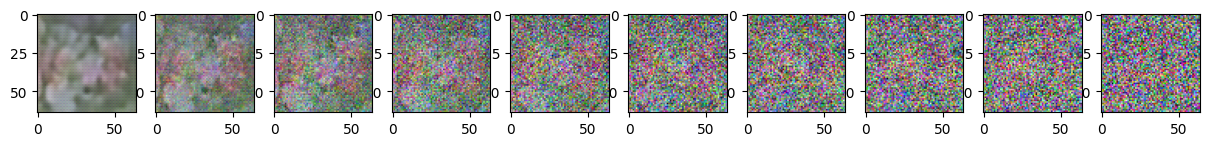

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

with tqdm(list(range(epochs))) as pbar:
  for epoch in pbar:
      for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        pbar.set_postfix({'loss': loss.item(), "step": step})

        if epoch % 5 == 0 and step == 0:
          # print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
          sample_plot_image()

### Expected results after training

Figure shows a deterministic sampling process (noisy images on top, predicted images on bottom)

![res](https://github.com/CausalLearningAI/applied-dl-tutorials/blob/main/t07/imgs/results.gif?raw=1)

**References**

- Ho, J., Jain, A. and Abbeel, P., 2020. Denoising diffusion probabilistic models. Advances in neural information processing systems, 33, pp.6840-6851.

- Song, Y., Sohl-Dickstein, J., Kingma, D.P., Kumar, A., Ermon, S. and Poole, B., 2020. Score-based generative modeling through stochastic differential equations. arXiv preprint arXiv:2011.13456.

- Dhariwal, P. and Nichol, A., 2021. Diffusion models beat gans on image synthesis. Advances in neural information processing systems, 34, pp.8780-8794.


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- [Keras DDIM tutorial](https://keras.io/examples/generative/ddim/)
- https://fanpu.io/blog/2023/score-based-diffusion-models/
- https://medium.com/@kemalpiro/step-by-step-visual-introduction-to-diffusion-models-235942d2f15c